https://medium.com/@CallMeTwitch/building-a-neural-network-zoo-from-scratch-the-recurrent-neural-network-9357b43e113c

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

In [1]:
import numpy as np, torch
from collections import Counter
from IPython.display import Image

<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>

<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/description-block-rnn-ltr.png" width=460 height=260 style="background-color:white" class="center"/>

Sentences with positive or negative mood

In [5]:
##### Data #####
train_X = ['good', 'bad', 'happy', 'sad', 'not good', 'not bad', 'not happy', 'not sad', 'very good', 'very bad', 'very happy', 'very sad', 'i am happy', 'this is good', 'i am bad', 'this is bad', 'i am sad', 'this is sad', 'i am not happy', 'this is not good', 'i am not bad', 'this is not sad', 'i am very happy', 'this is very good', 'i am very bad', 'this is very sad', 'this is very happy', 'i am good not bad', 'this is good not bad', 'i am bad not good', 'i am good and happy', 'this is not good and not happy', 'i am not at all good', 'i am not at all bad', 'i am not at all happy', 'this is not at all sad', 'this is not at all happy', 'i am good right now', 'i am bad right now', 'this is bad right now', 'i am sad right now', 'i was good earlier', 'i was happy earlier', 'i was bad earlier', 'i was sad earlier', 'i am very bad right now', 'this is very good right now', 'this is very sad right now', 'this was bad earlier', 'this was very good earlier', 'this was very bad earlier', 'this was very happy earlier', 'this was very sad earlier', 'i was good and not bad earlier', 'i was not good and not happy earlier', 'i am not at all bad or sad right now', 'i am not at all good or happy right now', 'this was not happy and not good earlier']
train_y = [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

test_X = ['this is happy', 'i am good', 'this is not happy', 'i am not good', 'this is not bad', 'i am not sad', 'i am very good', 'this is very bad', 'i am very sad', 'this is bad not good', 'this is good and happy', 'i am not good and not happy', 'i am not at all sad', 'this is not at all good', 'this is not at all bad', 'this is good right now', 'this is sad right now', 'this is very bad right now', 'this was good earlier', 'i was not happy and not good earlier']
test_y = [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]

collect all words and encode them into one-hot-vector

bonus: sort words by use frequency

In [6]:
words_all = [q for text in train_X for q in text.split()]
frequency = dict(Counter(words_all))
vocab_unique = list(sorted(frequency.keys(), key=lambda x: frequency[x], reverse=True))
print(vocab_unique)
vocab_size = len(vocab_unique)

word_to_index = {w:i for i, w in enumerate(vocab_unique)}

['not', 'i', 'this', 'good', 'bad', 'am', 'happy', 'very', 'is', 'sad', 'was', 'earlier', 'right', 'now', 'at', 'all', 'and', 'or']


In [7]:
def oneHotEncode(text: str) -> torch.Tensor:
    words = text.split()
    encode = torch.zeros(len(words),vocab_size)
    x,y = torch.tensor([(i,word_to_index[a]) for i,a in enumerate(words)]).T
    encode[x,y] = 1
    return encode
oneHotEncode('this is happy')

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Initialize network weights by 
https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/

In [31]:
# Xavier Normalized Initialization
def initWeights(input_size: int, output_size: int) -> torch.Tensor:
    rnd = torch.rand(size=(input_size, output_size))
    rnd = 2*rnd - 1
    return rnd * torch.sqrt(torch.tensor(6) / (input_size + output_size))

initWeights(2,2)

tensor([[ 1.0951, -0.2843],
        [ 1.1880,  1.0329]])

In [10]:
def tanh_p(x) -> torch.Tensor:
    return 1 - (torch.tanh(x)**2)

def softmax(x) -> torch.Tensor:
    y = torch.exp(x)
    return y / torch.sum(y)

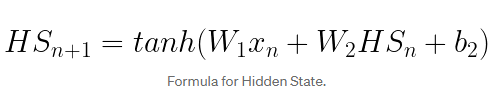

$$\mathrm{dim}(x_n) = (1,N_x)$$ 
$$\mathrm{dim}(HS_{n+1})  = (1,N_h) = \mathrm{dim}(b_2) = \mathrm{dim}(W_1 x_n) = \mathrm{dim}(W_2 HS_n)$$
$$\rightarrow \mathrm{dim}(W_2) = (N_h,N_h)$$
$$\rightarrow \mathrm{dim}(W_1) = (N_x,N_h) : \mathrm{dim}(W_1 x_n) = (1,N_x)(N_x,N_h)$$

In [ ]:
##### Recurrent Neural Network Class #####
class RNN:
    """
        input_size- one-hot length (vocabulary); hidden_size - internal buffer; output_size - negative/positive mood = 2
        hidden -> row vector (1,N)
        
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_epochs: int, learning_rate: float):
        # Hyperparameters
        self.learning_rate  = learning_rate
        self.num_epochs     = num_epochs
        
        # Network
        self.w1 = initWeights(input_size, hidden_size)
        self.w2 = initWeights(hidden_size, hidden_size)
        self.w3 = initWeights(hidden_size, output_size)

        self.b2 = torch.zeros((1, hidden_size))
        self.b3 = torch.zeros((1, output_size))
    
    # Forward Propagation
    def forward(self, inputs):
        self.hidden_states = torch.zeros(inputs.size(0),self.b2.size(1))#[torch.zeros_like(self.b2)]
        for i, x in enumerate(inputs):
            
        for input in inputs:
            layer1_output = np.dot(input, self.w1)
            layer2_output = np.dot(self.hidden_states[-1], self.w2) + self.b2
            
            self.hidden_states += [tanh(layer1_output + layer2_output)]

        return np.dot(self.hidden_states[-1], self.w3) + self.b3

In [17]:
torch.zeros((1, 3)).size(0)

1